Full testing/ training of 

LinearRegression, KNeighborsRegressor, and keras CNN

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
import numpy as np
from scipy.datasets import electrocardiogram
from scipy.signal import find_peaks, argrelmin, find_peaks_cwt
from collections import Counter
from scipy import signal
from pathlib import Path
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split
import pickle
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D,ConvLSTM1D, MaxPooling1D, Flatten, LSTM
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# Run this to get started
path_aurora_dataset = Path('/Users/cslinxs/Desktop/aurora_dataset/aurora_dataset/')


dictionary_aurora_50_sampled_path = "measurements_auscultatory_dictionary_ALL.pkl"
auscultatory_data = path_aurora_dataset / "measurements_auscultatory.tsv"
participants_data =  path_aurora_dataset / "participants.tsv"

# Use pwdb_model_configs file
participants_dps_csv_data = pd.read_csv("/Users/cslinxs/Desktop/all_weeks/pwdb_model_configs.csv")




with open(dictionary_aurora_50_sampled_path, 'rb') as handle:
    all_auscultatory_dic = pickle.load(handle)


bad_keys = []
for key, each_grouping in all_auscultatory_dic.items():
    if True in list(np.isnan(each_grouping[0])):
        bad_keys.append(key)
print(bad_keys)

for key in bad_keys:
    del all_auscultatory_dic[key]




keys_for_grouping = [
"Calibration_start",#0
"Static_challenge_start",#1
"Seated_calibration",#2
"Static_seated_challenge",#3
"Exercise_challenge_start",#4
"Temporal_challenge_start",#5
"Temporal_seated_challenge"]#6

['measurements_auscultatory/a064/a064.initial.Static_seated_challenge_1.tsv', 'measurements_auscultatory/a150/a150.return.Temporal_challenge_start_3.tsv', 'measurements_auscultatory/a328/a328.initial.Exercise_challenge_start_1.tsv', 'measurements_auscultatory/a578/a578.initial.Static_challenge_start_1.tsv', 'measurements_auscultatory/a596/a596.initial.Exercise_challenge_start_1.tsv', 'measurements_auscultatory/a642/a642.initial.Exercise_challenge_start_1.tsv', 'measurements_auscultatory/a648/a648.initial.Seated_calibration_1.tsv', 'measurements_auscultatory/a437/a437.initial.Exercise_challenge_start_2.tsv', 'measurements_auscultatory/a437/a437.return.Temporal_seated_challenge_2.tsv']


In [157]:
#all functions
def get_stats(check_list):
    standard = float(np.std(check_list))
    mean = float(np.mean(check_list))
    return [min(check_list, default="EMPTY"),mean-standard-standard,mean-standard,mean,mean + standard,mean +standard+standard ,max(check_list,default=0) ]

def reject_outliers(data):
    return data[abs(data - np.mean(data)) <3 * np.std(data)]

def get_50_avg_coordinates(path):
    print(path)
    df = pd.read_csv(path,sep = '\t')   
    pos_pressure = df["pressure"]

    neglist = [ -x for x in pos_pressure]

    # ADD THE DROPPING DWOAN AND GETMIN BELLOW a LINE
    b, a = signal.butter(1, 0.002, analog=False)
    gustafsson_avg = signal.filtfilt(b, a, x= pos_pressure, method="gust")
    y_flater = [real_pre-abs( guston_avg) for real_pre, guston_avg in zip(pos_pressure, gustafsson_avg)]

    y_flater = np.array(y_flater)
    neglist = [ -x for x in y_flater]

    neg_max_values = max(neglist)
    neg_mix_values = min(neglist)
    mid_neg_value= neg_max_values - neg_mix_values

    min_height = neg_max_values - mid_neg_value*0.15 

    min_peaks, _ = find_peaks(neglist , height= min_height)

    
    most_accurate_mins = min_peaks
    diffrences_new_min = reject_outliers(np.diff(most_accurate_mins))

    mean_new_min = float(diffrences_new_min.mean())
    overlapped_means = pd.DataFrame( )

    nans_list = np.full(int(mean_new_min- get_stats(diffrences_new_min)[1]), np.nan)
    
    for i in range(len(most_accurate_mins)-1):
        
        current_pulse_width = int(most_accurate_mins[i+1]) -int(most_accurate_mins[i])
        if (current_pulse_width)< get_stats(diffrences_new_min)[4] and (current_pulse_width)> get_stats(diffrences_new_min)[1]:
            y_range  = list(range(int(most_accurate_mins[i]),int(most_accurate_mins[i+1])))
            y_of_shift = [int(y - min(pos_pressure[y_range])) for y in pos_pressure[y_range]]


            start_end_line = np.linspace(y_of_shift[0], y_of_shift[-1], len(y_of_shift), endpoint=True)
            y_rotated = [xi - yi for xi, yi in zip(y_of_shift, start_end_line)]
            
            if len(y_rotated)>=int(mean_new_min):

                pulse_data_cut_short = pd.Series(list(y_rotated)[:int(mean_new_min)] )

                overlapped_means = pd.concat([overlapped_means, pulse_data_cut_short.rename(f"pulse {i}")], axis=1)
            else:
                
                pulse_data_and_Nan_filler = pd.Series(list(y_rotated)[:int(mean_new_min)] + list(nans_list[:int(mean_new_min) - len(y_rotated)]) )

                overlapped_means = pd.concat([overlapped_means, pulse_data_and_Nan_filler.rename(f"pulse {i}")], axis=1)

    overlapped_means['mean'] = overlapped_means.mean(axis=1)
    all_overlaps_means = (overlapped_means.mean(axis=1))
    resampled_y = signal.resample(all_overlaps_means, 50)
    return resampled_y



# Filter by activity
# Filters to activty's first file no overlap
def filter_by_activity(activity_number=1):
    if activity_number ==-1:
        auscultatory_pressure =[item[0] for item in all_auscultatory_dic.values()]
        auscultatory_sbp = [item[1] for item in all_auscultatory_dic.values()]
        auscultatory_dbp = [item[2] for item in all_auscultatory_dic.values()]
        return auscultatory_pressure,auscultatory_sbp,auscultatory_dbp 
    activity_tested_on = activity_number
    

    title_filtered_all_auscultatory_dic= dict(all_auscultatory_dic)
    for key, each_grouping in all_auscultatory_dic.items():
        if not(f"{keys_for_grouping[activity_tested_on]}_1" in  key):
            del title_filtered_all_auscultatory_dic[key]
    auscultatory_pressure =[item[0] for item in title_filtered_all_auscultatory_dic.values()]
    auscultatory_sbp = [item[1] for item in title_filtered_all_auscultatory_dic.values()]
    auscultatory_dbp = [item[2] for item in title_filtered_all_auscultatory_dic.values()]
    return auscultatory_pressure,auscultatory_sbp,auscultatory_dbp 


def filter_by_hypertension(activity_number=1):
    participants_auroa_data = pd.read_csv(participants_data, sep = '\t')
    participants_csv_htn = participants_auroa_data[participants_auroa_data["self_report_htn"].isin(["managed","unmanaged"])]
    participants_csv_htn = participants_csv_htn[participants_csv_htn["pid"].str.contains('a')]
    people_htn = participants_csv_htn["pid"]

    title_filtered_all_auscultatory_dic= dict(all_auscultatory_dic)
    for key, each_grouping in all_auscultatory_dic.items():
        person_id = key.split("_")[1].split("/")[1]
        if not(person_id in list(people_htn)): 
            del title_filtered_all_auscultatory_dic[key]


    if activity_number ==-1:
        auscultatory_pressure =[item[0] for item in all_auscultatory_dic.values()]
        auscultatory_sbp = [item[1] for item in all_auscultatory_dic.values()]
        auscultatory_dbp = [item[2] for item in all_auscultatory_dic.values()]
        return auscultatory_pressure,auscultatory_sbp,auscultatory_dbp 
    activity_tested_on = activity_number
    
    title_filtered_all_auscultatory_dic_2= dict(title_filtered_all_auscultatory_dic) 
    for key, each_grouping in title_filtered_all_auscultatory_dic.items():
        if not(f"{keys_for_grouping[activity_tested_on]}_1" in  key):
            del title_filtered_all_auscultatory_dic_2[key]
    auscultatory_pressure =[item[0] for item in title_filtered_all_auscultatory_dic_2.values()]
    auscultatory_sbp = [item[1] for item in title_filtered_all_auscultatory_dic_2.values()]
    auscultatory_dbp = [item[2] for item in title_filtered_all_auscultatory_dic_2.values()]
    return auscultatory_pressure,auscultatory_sbp,auscultatory_dbp 

# Filters by systolic value
def filter_by_sbp(SBP_range = (120,120), activity_number=1):
    activity_tested_on = activity_number

    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp= filter_by_activity(activity_number)
    title_filtered_all_auscultatory_dic= dict(all_auscultatory_dic)
    for i in [sb for sb in range(len(auscultatory_sbp)) if (float(auscultatory_dbp[sb])<=SBP_range[0] and float(auscultatory_sbp[sb])>SBP_range[1]  ) ][::-1]:
        #print("hi")
        auscultatory_pressure.pop(i)
        auscultatory_sbp.pop(i)
        auscultatory_dbp.pop(i)
    return auscultatory_pressure,auscultatory_sbp,auscultatory_dbp 

# Filters by systolic value
def filter_by_dbp(DBP_range = (70,80), activity_number=1):
    activity_tested_on = activity_number

    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp= filter_by_activity(activity_number)
    title_filtered_all_auscultatory_dic= dict(all_auscultatory_dic)
    for i in [sb for sb in range(len(auscultatory_dbp)) if (float(auscultatory_dbp[sb])<=DBP_range[0] and float(auscultatory_dbp[sb])>DBP_range[1]  ) ][::-1]:
        #print("hi")
        auscultatory_pressure.pop(i)
        auscultatory_sbp.pop(i)
        auscultatory_dbp.pop(i)
    return auscultatory_pressure,auscultatory_sbp,auscultatory_dbp 


def filter_charlton_subjects():
    charlton_point_dbp = [[],[],[]]

    # will track age,dbp values
    charlton_set_seen_duplicates =set()

    Charlton_dataset_csv = "/Users/cslinxs/Desktop/all_weeks/Charlton_dataset_csv"
    for files in os.listdir(Charlton_dataset_csv):
        if "_P.Csv" in files.title() and "Digital" in files.title():
            body_part = files.title().split("_")[1]
            function = files.title().split("_")[2]
            participants_csv_data = pd.read_csv(Charlton_dataset_csv+"/"+files)
            
            for i in range(len(participants_csv_data)):
                y_points = participants_csv_data.iloc[i][1:].dropna()
                
                resampled_y = signal.resample(y_points, 50)
                resampled_y = [int(y - min(resampled_y)) for y in resampled_y]
                
                if not(True in list(np.isnan(resampled_y))):
                    indivuals_set = (participants_dps_csv_data.get(" age [years]")[i],participants_dps_csv_data.get(" dbp [mmHg]")[i],participants_dps_csv_data.get(" pvr [Pa s/m^3]")[i])
                    if not(indivuals_set in charlton_set_seen_duplicates):
                        charlton_point_dbp[0].append(resampled_y)
                        charlton_point_dbp[1].append(participants_dps_csv_data.get(" dbp [mmHg]")[i])
                        charlton_point_dbp[2].append(participants_dps_csv_data.get(" mbp [mmHg]")[i])
                        
                        charlton_set_seen_duplicates.add(indivuals_set)
    return charlton_point_dbp[0], charlton_point_dbp[1]

def LinearRegression_plot_MAE( activity_number=1):
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = filter_by_activity(activity_number)

    all_points = np.array(auscultatory_pressure)
    all_points = all_points.reshape(all_points.shape[0], -1)

    plt.figure(figsize=(5, 5)) 
    neigh = LinearRegression()


    X_train, X_test, Y_train, Y_test = train_test_split(all_points, auscultatory_dbp, test_size=0.3)




    the_fit= neigh.fit(X_train, Y_train)

    y_predict= neigh.predict(X_test)

    plt.rcParams.update({'font.size': 10})

    plt.plot(Y_test, Y_test, color="grey", linewidth=2, alpha=0.9)


    plt.scatter(Y_test, list(y_predict),  color="red",  alpha=0.5,s=50 )
    plt.title(f"LinearRegression Activity: {keys_for_grouping[activity_number]}")
    plt.xlabel("Tested DBP value")
    plt.ylabel("Predicted DBP value")

    xmin, xmax, ymin, ymax = plt.axis()
    plt.text(xmax+0.25, ymin+(ymax-ymin)*0.4,s=f"MAE {round(mean_absolute_error(Y_test, y_predict),2)}", fontsize=12)
    plt.text(xmax+0.25, ymin+(ymax-ymin)*0.2, s= f"RMS {round(root_mean_squared_error(Y_test, y_predict),2)}", fontsize=12)
    plt.text(xmax+0.25, ymin, s= f"r2 {round(r2_score(Y_test, y_predict),2)}", fontsize=12)
    plt.show()
    return round(mean_absolute_error(Y_test, y_predict),2)


def KNN_MAE_cross( activity_number=1, bp_variable = "s", n_neighbors=1, cross_valid_space = 50):
    
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = [], [], []
    
    bp_variable_val = None
    if bp_variable=="c":
        auscultatory_pressure, auscultatory_dbp = filter_charlton_subjects()
        bp_variable_val = auscultatory_dbp
    else: 
        auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = filter_by_activity(activity_number)
        if bp_variable=="d":
            bp_variable_val = auscultatory_dbp
        elif bp_variable=="s":
            bp_variable_val = auscultatory_sbp

    all_mea = []

    for i in range(0,len(auscultatory_pressure),cross_valid_space): 

        X = auscultatory_pressure[0:i] + auscultatory_pressure[i+cross_valid_space:len(auscultatory_pressure)]
        Y = np.array(bp_variable_val[0:i] +bp_variable_val[i+cross_valid_space:len(auscultatory_pressure)])
        
        X_other = auscultatory_pressure[i:i+cross_valid_space] 
        Y_other = np.array(bp_variable_val[i:i+cross_valid_space])
        
        X_train= np.array(X)
        Y_train= np.array(Y)

        X_test= np.array(X_other)
        Y_test= np.array(Y_other)

        X_test = X_test.reshape(X_test.shape[0], -1)
        Y_test = Y_test.reshape(Y_test.shape[0], -1)

        model = KNeighborsRegressor(n_neighbors=n_neighbors)

        X_test = X_test.reshape(X_test.shape[0], -1)

        the_fit = model.fit(X_train, Y_train)

        y_predict= model.predict(X_test)

        all_mea.append(round(mean_absolute_error(Y_test, y_predict),2))
        plt.rcParams.update({'font.size': 10})

    return [get_stats(all_mea)[3], get_stats(all_mea)[4] - get_stats(all_mea)[3] ]

def LinearRegression_MAE_cross( activity_number=1, bp_variable = "s", cross_valid_space = 50):
    
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = [], [], []
    
    bp_variable_val = None
    if bp_variable=="c":
        auscultatory_pressure, auscultatory_dbp = filter_charlton_subjects()
        bp_variable_val = auscultatory_dbp
    else: 
        auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = filter_by_activity(activity_number)
        if bp_variable=="d":
            bp_variable_val = auscultatory_dbp
        elif bp_variable=="s":
            bp_variable_val = auscultatory_sbp

    all_mea = []

    for i in range(0,len(auscultatory_pressure),cross_valid_space): 

        X = auscultatory_pressure[0:i] + auscultatory_pressure[i+cross_valid_space:len(auscultatory_pressure)]
        Y = np.array(bp_variable_val[0:i] +bp_variable_val[i+cross_valid_space:len(auscultatory_pressure)])
        
        X_other = auscultatory_pressure[i:i+cross_valid_space] 
        Y_other = np.array(bp_variable_val[i:i+cross_valid_space])
        
        X_train= np.array(X)
        Y_train= np.array(Y)

        X_test= np.array(X_other)
        Y_test= np.array(Y_other)

        

        X_test = X_test.reshape(X_test.shape[0], -1)
        Y_test = Y_test.reshape(Y_test.shape[0], -1)

        model = LinearRegression()

        X_test = X_test.reshape(X_test.shape[0], -1)

        the_fit = model.fit(X_train, Y_train)

        y_predict= model.predict(X_test)

        all_mea.append(round(mean_absolute_error(Y_test, y_predict),2))

    return [get_stats(all_mea)[3], get_stats(all_mea)[4] - get_stats(all_mea)[3] ]

                    

def CNN_MAE_cross( activity_number=1, bp_variable = "s", cross_valid_space = 50):
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = [], [], []
    
    bp_variable_val = None
    if bp_variable=="c":
        # auscultatory_pressure, auscultatory_dbp = filter_charlton_subjects()
        # bp_variable_val = auscultatory_dbp
        print("Use [CNN_MAE_cross_charlton] method")
        return None
    else: 
        auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = filter_by_activity(activity_number)
        if bp_variable=="d":
            bp_variable_val = auscultatory_dbp
        elif bp_variable=="s":
            bp_variable_val = auscultatory_sbp


    all_mea = []

    for i in range(0,len(auscultatory_pressure),cross_valid_space): 

        X = auscultatory_pressure[0:i] + auscultatory_pressure[i+cross_valid_space:len(auscultatory_pressure)]
        Y = np.array(bp_variable_val[0:i] +bp_variable_val[i+cross_valid_space:len(auscultatory_pressure)])
        
        X_other = auscultatory_pressure[i:i+cross_valid_space] 
        Y_other = np.array(bp_variable_val[i:i+cross_valid_space])
        
        X_train= np.array(X)
        Y_train= np.array(Y)

        X_test= np.array(X_other)
        Y_test= np.array(Y_other)

        X_test = X_test.reshape(X_test.shape[0], -1)
        Y_test = Y_test.reshape(Y_test.shape[0], -1)

        def create_model():
            model = Sequential()
            model.add(Conv1D(filters=32, kernel_size=2,strides=2, activation='relu', input_shape=((X_train).shape[1], 1)))
            model.add(Dropout(0.5))
            model.add(Conv1D(64, kernel_size=5, strides=5, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Conv1D(128, kernel_size=3, strides=1, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Flatten())
            model.add(Dense(1))
            optimizer = RMSprop(0.001)
            model.compile(loss='mse',
                        optimizer=optimizer,
                        metrics=['mae',])
            return model
        model = create_model()
        history = model.fit(X_train, tf.stack(Y_train), epochs=50, validation_split=0.3)
        test_loss, test_accuracy = model.evaluate(X_test,tf.stack(Y_test) )


        all_mea.append(test_accuracy)
        

    return [get_stats(all_mea)[3], get_stats(all_mea)[4] - get_stats(all_mea)[3] ]

def CNN_MAE_cross_charlton( activity_number=1, bp_variable = "s", cross_valid_space = 50):
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = [], [], []
    
    bp_variable_val = None
    if bp_variable=="c":
        auscultatory_pressure, auscultatory_dbp = filter_charlton_subjects()
        bp_variable_val = auscultatory_dbp
    else: 
        print("Use [CNN_MAE_cross] method")
        return None


    all_mea = []
    cross_valid_space=50
    for i in range(0,len(auscultatory_pressure),50): 
        X = auscultatory_pressure[0:cross_valid_space] + auscultatory_pressure[cross_valid_space+cross_valid_space:len(auscultatory_pressure)]
        Y = np.array(bp_variable_val[0:cross_valid_space] +bp_variable_val[cross_valid_space+cross_valid_space:len(bp_variable_val)])
        
        X_other = auscultatory_pressure[cross_valid_space:cross_valid_space+50] 
        Y_other = np.array(bp_variable_val[cross_valid_space:cross_valid_space+50])

        
        X_train= np.array(X)
        Y_train= np.array(Y)

        X_test= np.array(X_other)
        Y_test= np.array(Y_other)



        def create_model():
            model = Sequential()
            model.add(Conv1D(filters=32, kernel_size=2,strides=2, activation='relu', input_shape=((X_train).shape[1], 1)))
            model.add(Dropout(0.5))
            model.add(Conv1D(64, kernel_size=5, strides=5, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Conv1D(128, kernel_size=3, strides=1, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Flatten())
            model.add(Dense(1))
            optimizer = RMSprop(0.001)

            model.compile(loss='mse',
                        optimizer=optimizer,
                        metrics=['mae',])

            return model
        model = create_model()
        
        history = model.fit(X_train, tf.stack(Y_train), epochs=50, validation_split=0.3)
        test_loss, test_accuracy = model.evaluate(X_test,tf.stack(Y_test) )


        all_mea.append(test_accuracy)
    return [get_stats(all_mea)[3], get_stats(all_mea)[4] - get_stats(all_mea)[3] ]


def CNN_MAE_cross_simvreal( activity_number=1, bp_variable = "s", cross_valid_space = 50):
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = [], [], []
    auscultatory_pressure_real, auscultatory_sbp_real, auscultatory_dbp_real = [], [], []

    bp_variable_val = None

    if bp_variable=="c":
        auscultatory_pressure, auscultatory_dbp = filter_charlton_subjects()
        bp_variable_val = auscultatory_dbp

        auscultatory_pressure_real, auscultatory_sbp_real, auscultatory_dbp_real = filter_by_activity(activity_number)
    else: 
        print("Use [CNN_MAE_cross] method")
        return None


    all_mea = []
    cross_valid_space=50
    for i in range(0,len(auscultatory_pressure),50): 
        X = auscultatory_pressure[0:cross_valid_space] + auscultatory_pressure[cross_valid_space+cross_valid_space:len(auscultatory_pressure)]
        Y = np.array(bp_variable_val[0:cross_valid_space] +bp_variable_val[cross_valid_space+cross_valid_space:len(bp_variable_val)])
        

        #tested on real
        X_other = auscultatory_pressure_real[cross_valid_space:cross_valid_space+50] 
        Y_other = np.array(auscultatory_dbp_real[cross_valid_space:cross_valid_space+50])

        #trained on simulation
        X_train= np.array(X)
        Y_train= np.array(Y)

        X_test= np.array(X_other)
        Y_test= np.array(Y_other)



        def create_model():
            model = Sequential()
            model.add(Conv1D(filters=32, kernel_size=2,strides=2, activation='relu', input_shape=((X_train).shape[1], 1)))
            model.add(Dropout(0.5))
            model.add(Conv1D(64, kernel_size=5, strides=5, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Conv1D(128, kernel_size=3, strides=1, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Flatten())
            model.add(Dense(1))
            optimizer = RMSprop(0.001)

            model.compile(loss='mse',
                        optimizer=optimizer,
                        metrics=['mae',])

            return model
        model = create_model()
        
        history = model.fit(X_train, tf.stack(Y_train), epochs=50, validation_split=0.3)
        test_loss, test_accuracy = model.evaluate(X_test,tf.stack(Y_test) )


        all_mea.append(test_accuracy)
    print(all_mea)

    def plot_history(history):
        plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('Mean Abs Error')
        plt.plot(history.epoch, np.array(history.history['mae']), 
                label='Train')
        plt.plot(history.epoch, np.array(history.history['val_mae']),
                label = 'Val')
        plt.legend()
        plt.ylim([min(history.history['val_mae']),max(history.history['val_mae'])])
    plot_history(history)


    return [get_stats(all_mea)[3], get_stats(all_mea)[4] - get_stats(all_mea)[3] ]


def CNN_MAE_cross_realvsim( activity_number=1, bp_variable = "s", cross_valid_space = 50):
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = [], [], []
    auscultatory_pressure_real, auscultatory_sbp_real, auscultatory_dbp_real = [], [], []

    bp_variable_val = None

    if bp_variable=="c":
        auscultatory_pressure, auscultatory_dbp = filter_charlton_subjects()
        bp_variable_val = auscultatory_dbp

        auscultatory_pressure_real, auscultatory_sbp_real, auscultatory_dbp_real = filter_by_activity(activity_number)
    else: 
        print("Use [CNN_MAE_cross] method")
        return None


    all_mea = []
    cross_valid_space=50
    for i in range(0,len(auscultatory_pressure),50): 
        X = auscultatory_pressure_real[0:cross_valid_space] + auscultatory_pressure_real[cross_valid_space+cross_valid_space:len(auscultatory_pressure)]
        Y = np.array(auscultatory_dbp_real[0:cross_valid_space] +auscultatory_dbp_real[cross_valid_space+cross_valid_space:len(bp_variable_val)])
        

        #tested on simulated 
        X_other = auscultatory_pressure[cross_valid_space:cross_valid_space+50] 
        Y_other = np.array(auscultatory_dbp[cross_valid_space:cross_valid_space+50])

        #trained on real
        X_train= np.array(X)
        Y_train= np.array(Y)

        X_test= np.array(X_other)
        Y_test= np.array(Y_other)



        def create_model():
            model = Sequential()
            model.add(Conv1D(filters=32, kernel_size=2,strides=2, activation='relu', input_shape=((X_train).shape[1], 1)))
            model.add(Dropout(0.5))
            model.add(Conv1D(64, kernel_size=5, strides=5, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Conv1D(128, kernel_size=3, strides=1, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Flatten())
            # model.add(Dense(1))
            optimizer = RMSprop(0.001)

            model.compile(loss='mse',
                        optimizer=optimizer,
                        metrics=['mae',])

            return model
        model = create_model()
        
        history = model.fit(X_train, tf.stack(Y_train), epochs=50, validation_split=0.3)
        test_loss, test_accuracy = model.evaluate(X_test,tf.stack(Y_test) )


        all_mea.append(test_accuracy)
    print(all_mea)
    return [get_stats(all_mea)[3], get_stats(all_mea)[4] - get_stats(all_mea)[3] ]

        
        

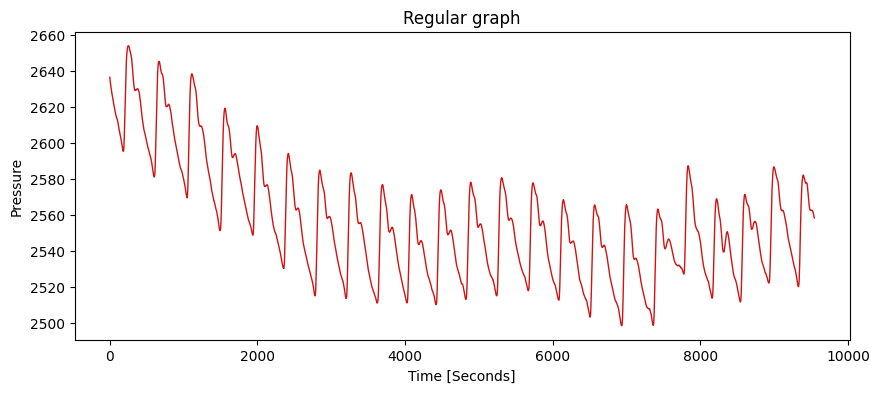

In [106]:
path = "/Users/cslinxs/Desktop/all_weeks/aurorabp-sample-data/sample/measurements_auscultatory/a002/a002.initial.Static_seated_challenge_1.tsv"

df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]

plt.figure(figsize=(10, 4)) 
plt.rcParams.update({'font.size': 10})

plt.plot(pos_pressure,  linewidth=1, label='real', color= "#D21312")

plt.title("Regular graph")
# plt.legend(loc='best')
plt.ylabel("Pressure")
plt.xlabel("Time [Seconds]")
plt.show()

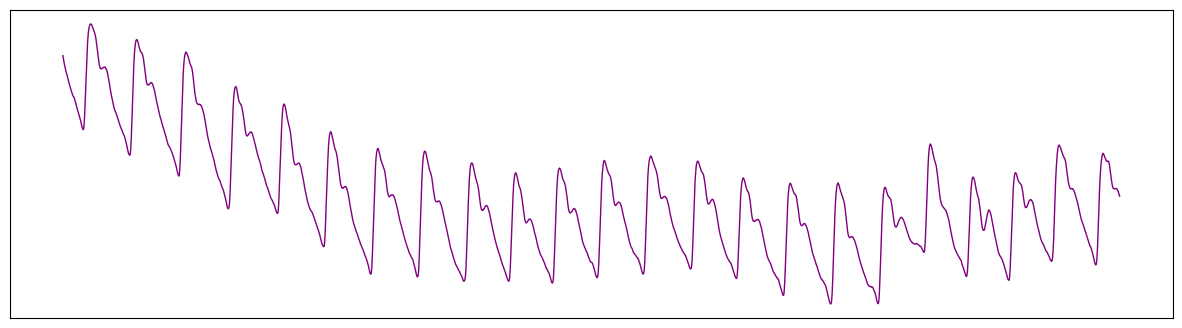

In [6]:
#path = "/Users/cslinxs/Desktop/all_weeks/aurorabp-sample-data/sample/measurements_auscultatory/a004/a004.initial.Exercise_challenge_start_1.tsv"

df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]

plt.figure(figsize=(15, 4)) 
plt.rcParams.update({'font.size': 10})

plt.plot(pos_pressure,  linewidth=1, label='real', color= "purple")

plt.xticks([])
plt.yticks([])

plt.show()

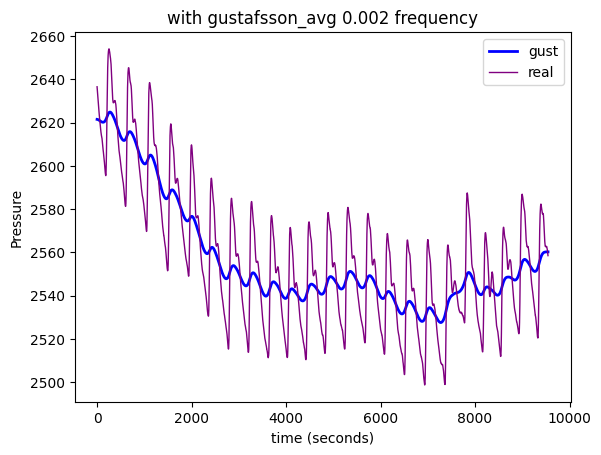

In [7]:
df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]


b, a = signal.butter(1, 0.002, analog=False)
gustafsson_avg = signal.filtfilt(b, a, x= pos_pressure, method="gust")
plt.plot(gustafsson_avg, 'b-', linewidth=2, label='gust',)
plt.plot(pos_pressure,  linewidth=1, label='real', color= "purple")

plt.title("with gustafsson_avg 0.002 frequency")
plt.legend(loc='best')
plt.ylabel("Pressure")
plt.xlabel("time (seconds)")
plt.show()

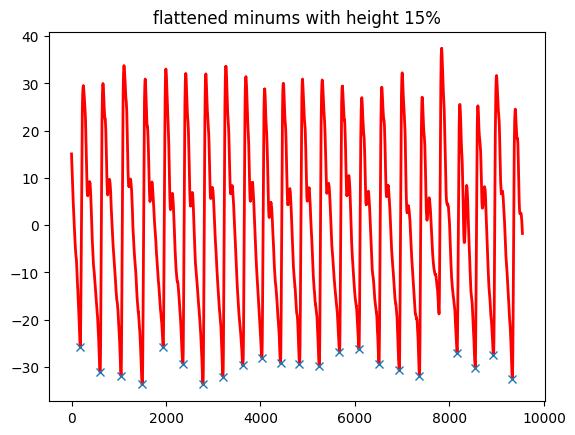

In [8]:

# df = pd.read_csv(path,sep = '\t')   
# pos_pressure = df["pressure"]

y_flater = [real_pre-abs( guston_avg) for real_pre, guston_avg in zip(pos_pressure, gustafsson_avg)]

y_flater = np.array(y_flater)
neglist = [ -x for x in y_flater]

neg_max_values = max(neglist)
neg_mix_values = min(neglist)
mid_neg_value= neg_max_values - neg_mix_values

min_height = neg_max_values - mid_neg_value*0.15 

min_peaks, _ = find_peaks(neglist , height= min_height, width=50)


plt.plot(y_flater, color="red", linewidth=2)
plt.plot(min_peaks, y_flater[min_peaks], "x",)
plt.title("flattened minums with height 15%")
plt.show()


In [9]:
most_accurate_mins = min_peaks
diffrences_new_min = reject_outliers(np.diff(most_accurate_mins))

mean_new_min = float(diffrences_new_min.mean())
overlapped_means = pd.DataFrame( )

nans_list = np.full(int(mean_new_min- get_stats(diffrences_new_min)[1]), np.nan)

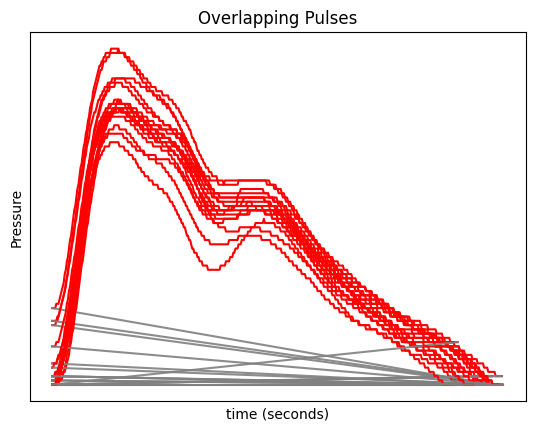

In [10]:
all_overlaps = [[] for i in range(int(max(diffrences_new_min)))]

df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]

newst_mins= np.asarray(list(most_accurate_mins), dtype=np.float32)

mini_list = list(newst_mins)

for i in range(len(mini_list)-1):

    if (int(mini_list[i+1]) -int(mini_list[i]))< get_stats(diffrences_new_min)[4] :
        y_range  = list(range(int(mini_list[i]),int(mini_list[i+1])))
        y_of_shift = [int(y - min(pos_pressure[y_range])) for y in pos_pressure[y_range]]
 
        x_range = list(range(int(mini_list[i]),int(mini_list[i+1])))
        x_of_shift = [int(x - x_range[0]) for x in x_range]
        start_end_line = np.linspace(y_of_shift[0], y_of_shift[-1], len(y_of_shift), endpoint=True)

        y_rotated = [xi - yi for xi, yi in zip(y_of_shift, start_end_line)]


        for x_indi in range(len(x_range)):
            all_overlaps[x_indi].append(int(y_of_shift[x_indi]-start_end_line[x_indi]))

        plt.plot(y_of_shift, color="red")
        plt.plot(start_end_line,color="grey" , alpha=0.9)


plt.title("Overlapping Pulses")
plt.ylabel("Pressure")
plt.xlabel("time (seconds)")
plt.xticks([])
plt.yticks([])

plt.show()

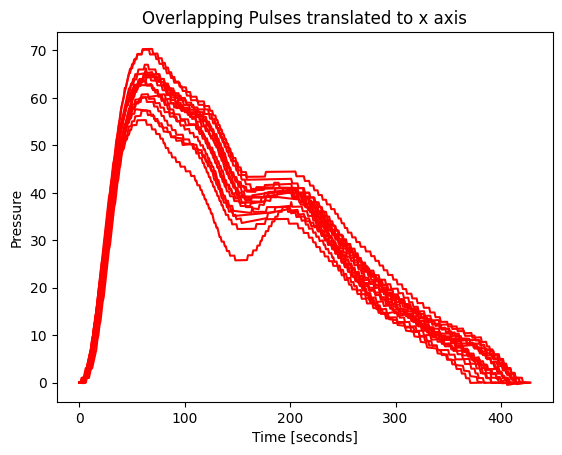

In [11]:
all_overlaps = [[] for i in range(int(max(diffrences_new_min)))]

df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]

newst_mins= np.asarray(list(most_accurate_mins), dtype=np.float32)

mini_list = list(newst_mins)

for i in range(len(mini_list)-1):

    if (int(mini_list[i+1]) -int(mini_list[i]))< get_stats(diffrences_new_min)[4] :
        y_range  = list(range(int(mini_list[i]),int(mini_list[i+1])))
        y_of_shift = [int(y - min(pos_pressure[y_range])) for y in pos_pressure[y_range]]
 
        x_range = list(range(int(mini_list[i]),int(mini_list[i+1])))
        x_of_shift = [int(x - x_range[0]) for x in x_range]
        start_end_line = np.linspace(y_of_shift[0], y_of_shift[-1], len(y_of_shift), endpoint=True)

        y_rotated = [xi - yi for xi, yi in zip(y_of_shift, start_end_line)]


        for x_indi in range(len(x_range)):
            all_overlaps[x_indi].append(int(y_of_shift[x_indi]-start_end_line[x_indi]))

        plt.plot(y_rotated, color="red")


plt.title("Overlapping Pulses translated to x axis")
plt.ylabel("Pressure")
plt.xlabel("Time [seconds]")

plt.show()

/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


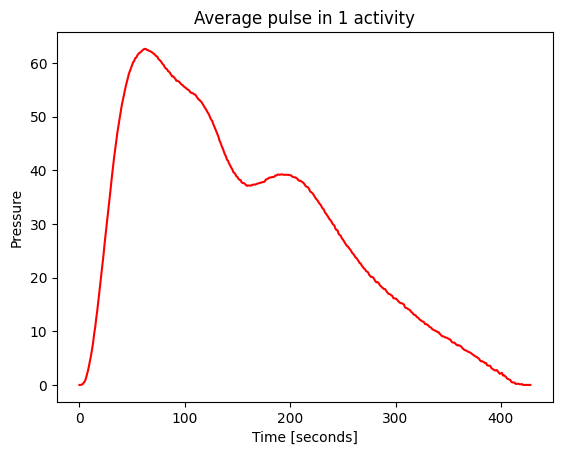

In [12]:
#to get data for the overall mean 
all_overlaps_means = []
#mean for each row
for lists in all_overlaps:
    all_overlaps_means.append(np.mean(lists))

all_overlaps_means = [x for x in all_overlaps_means if str(x) != 'nan']
plt.plot(all_overlaps_means, color='red')
plt.title("Average pulse in 1 activity")
plt.ylabel("Pressure")
plt.xlabel("Time [seconds]")
contecting_it = np.linspace(all_overlaps_means[0], all_overlaps_means[-1], len(all_overlaps_means), endpoint=True)
plt.show()
all_overlaps_means = [x for x in all_overlaps_means if str(x) != 'nan']


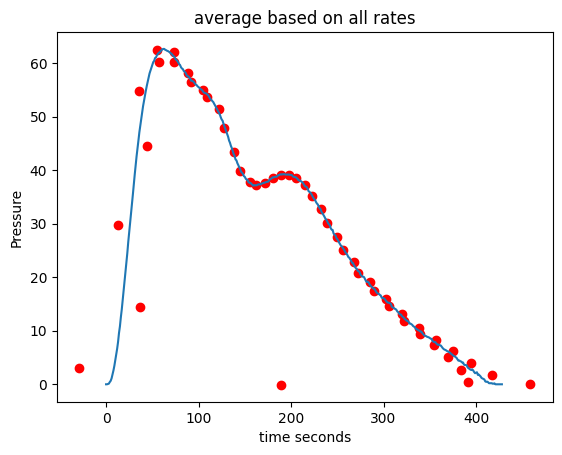

In [13]:
#to get data for the overall mean 
all_overlaps_means = []
#mean for each row
for lists in all_overlaps:
    all_overlaps_means.append(np.mean(lists))

all_overlaps_means = [x for x in all_overlaps_means if str(x) != 'nan']

resampled_y = signal.resample(all_overlaps_means, 50)
resampled_x = signal.resample(list(range(len(all_overlaps_means))), 50)


plt.plot(resampled_x,resampled_y,  'ro' )
plt.plot(all_overlaps_means )

plt.title("average based on all rates")
plt.ylabel("Pressure")
plt.xlabel("time seconds")

plt.show()

Demos are done.


Training Models:

Making the chart for aurora

In [14]:

# LinearRegression_MAE_cross(-1, "s",1000)

# KNN_MAE_cross(-1, "s",1000)

# CNN_MAE_cross(-1, "s",1000)

# #or Run no overlap in participants , 0=Calibration_start recordings

# LinearRegression_MAE_cross(0, "s",50)

# KNN_MAE_cross(0, "s",50)

# CNN_MAE_cross(0, "s",50)

# CNN_MAE_cross_simvreal(6,"c")



<Axes: >

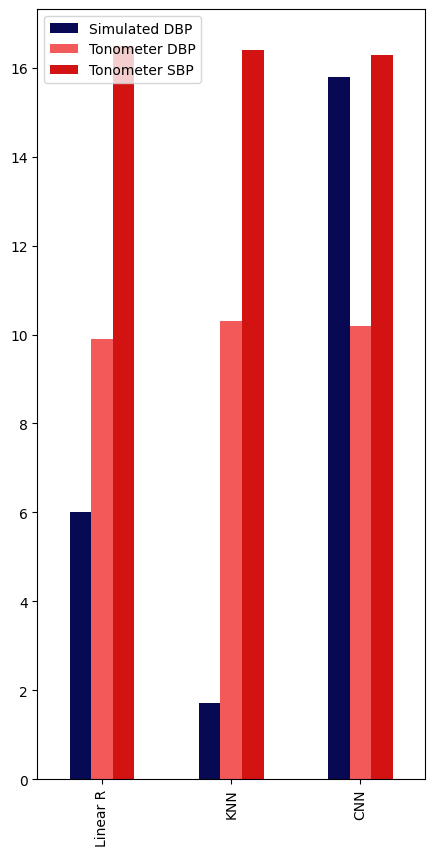

In [247]:
models_list = ("Linear Regression"," KNN","CNN")



#simulated_data = (1,1.7, 13.9)
simulated_data = (6,1.7, 15.8)

simulated_sdp =(25.08, 6.7, 19.3)
aura_dpb = (9.9, 10.3, 10.2)
auroa_sbp = (16.5, 16.4, 16.3)

_data = {'Simulated DBP': simulated_data,
         #'Simulated SBP': simulated_sdp,
        'Tonometer DBP':aura_dpb,
        "Tonometer SBP":auroa_sbp}
_df = pd.DataFrame(_data,columns=list(_data), index = ['Linear R', 'KNN', 'CNN'])

_df.plot.bar(figsize=(5,10),color=[ "#070A52", "#F15A59","#D21312" ])
#"#522258",
# plt.show()

Done with Auroa and Charlton

Now I want to makethe graph chart

In [15]:
# all_models = {}

# for i in range(len(keys_for_grouping)):
#     all_models[keys_for_grouping[i]]= [LinearRegression_MAE_cross(i, "s",50),KNN_MAE_cross(i, "s",50) , CNN_MAE_cross(i, "s",10)]

# list_results = []
# for i in range(0,7):
#     list_results.append(CNN_MAE_cross_both(i,"c"))

# print(list_results)



Showing clustering

In [264]:
auscultatory_pressure_real, auscultatory_sbp_real, auscultatory_dbp_real = filter_by_activity(4)
#auscultatory_pressure_real, auscultatory_sbp_real, auscultatory_dbp_real = filter_by_hypertension(-1)

In [81]:
len(filter_by_hypertension(0)[0])

226

75.4 13.0
127.5 18.0


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/1326597042.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/1326597042.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]


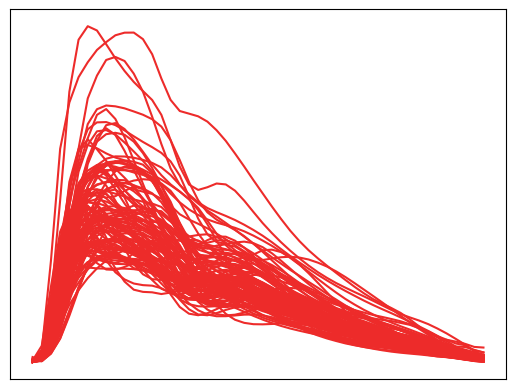

74.3 12.3
122.7 19.7


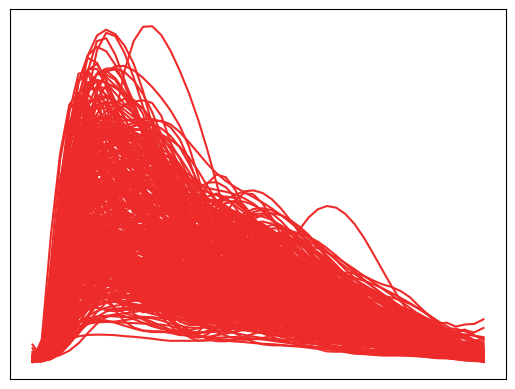

In [248]:
#this prints all the pulses
from sklearn.cluster import KMeans
n_clusters=2
kmeans = KMeans(n_clusters=n_clusters)

y = kmeans.fit_predict(auscultatory_pressure_real)

#print(y)
for j in range(n_clusters):
    indexes = [idx for idx, val in enumerate(y) if val == j]
    dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
    dbp_variation=list(dbp_variation)
    sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
    sbp_variation =list(sbp_variation)
    #print(sbp_variation)
    print(round(get_stats(dbp_variation)[3],1), round(get_stats(dbp_variation)[4] - get_stats(dbp_variation)[3],1) )
    print(round(get_stats(sbp_variation)[3],1), round(get_stats(sbp_variation)[4] - get_stats(sbp_variation)[3],1))
    for i in indexes:
        plt.plot(auscultatory_pressure_real[i], color="#ED2B2A")
    #plt.title(f"With {len(indexes)} in the group")
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [270]:
# I want to show as you add a pulse the avegera SD error goes down
from sklearn.cluster import KMeans
# n_clusters=110
# kmeans = KMeans(n_clusters=n_clusters)

# y = kmeans.fit_predict(auscultatory_pressure_real)

# #print(y)
# for j in range(n_clusters):
    # indexes = [idx for idx, val in enumerate(y) if val == j]
    # dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
    # dbp_variation=list(dbp_variation)
    # sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
    # sbp_variation =list(sbp_variation)
    # #print(sbp_variation)
    # print(round(get_stats(dbp_variation)[3],1), round(get_stats(dbp_variation)[4] - get_stats(dbp_variation)[3],1) )
#     print(round(get_stats(sbp_variation)[3],1), round(get_stats(sbp_variation)[4] - get_stats(sbp_variation)[3],1))
#     for i in indexes:
#         plt.plot(auscultatory_pressure_real[i], color="#ED2B2A")
#     #plt.title(f"With {len(indexes)} in the group")
#     plt.xticks([])
#     plt.yticks([])
#     plt.show()

all_kmeans_sd =[]
all_kmeans_mean =[]
all_kmeans_numbers = []
for k in range(1, 400):

    
    kmeans = KMeans(n_clusters=k,  max_iter = 500).fit(auscultatory_pressure_real)
    y = kmeans.fit_predict(auscultatory_pressure_real)
    #print(y)
    list_kmean_sd =[]
    list_kmean_mean =[]
    list_kmean_nums =[]
    for j in range(k):
        indexes = [idx for idx, val in enumerate(y) if val == j]
        dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
        dbp_variation=list(dbp_variation)
        sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
        sbp_variation =list(sbp_variation)
        #print(sbp_variation)
        list_kmean_mean.append(round(get_stats(dbp_variation)[3],1) )
        list_kmean_sd.append(round(get_stats(dbp_variation)[4] - get_stats(dbp_variation)[3],1) )
        list_kmean_nums.append(len(indexes))
    all_kmeans_sd.append(sum(list_kmean_sd) / len(list_kmean_sd))
    all_kmeans_mean.append(sum(list_kmean_mean) / len(list_kmean_mean))
    all_kmeans_numbers.append(sum(list_kmean_nums) / len(list_kmean_nums))

/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/4241696087.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/4241696087.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/4241696087.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

In [ ]:
#simulated finding right K means

# I want to show as you add a pulse the avegera SD error goes down
from sklearn.cluster import KMeans


all_kmeans_sd =[]
all_kmeans_mean =[]
all_kmeans_numbers = []
for k in range(1, 50):

    
    kmeans = KMeans(n_clusters=k,  max_iter = 500).fit(auscultatory_pressure_simulated)
    y = kmeans.fit_predict(auscultatory_pressure_simulated)
    #print(y)
    list_kmean_sd =[]
    list_kmean_mean =[]
    list_kmean_nums =[]
    for j in range(k):
        indexes = [idx for idx, val in enumerate(y) if val == j]
        dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_simulated)) if j in indexes]
        dbp_variation=list(dbp_variation)
        sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_simulated)) if j in indexes]
        sbp_variation =list(sbp_variation)
        #print(sbp_variation)
        list_kmean_mean.append(round(get_stats(dbp_variation)[3],1) )
        list_kmean_sd.append(round(get_stats(dbp_variation)[4] - get_stats(dbp_variation)[3],1) )
        list_kmean_nums.append(len(indexes))
    all_kmeans_sd.append(sum(list_kmean_sd) / len(list_kmean_sd))
    all_kmeans_mean.append(sum(list_kmean_mean) / len(list_kmean_mean))
    all_kmeans_numbers.append(sum(list_kmean_nums) / len(list_kmean_nums))

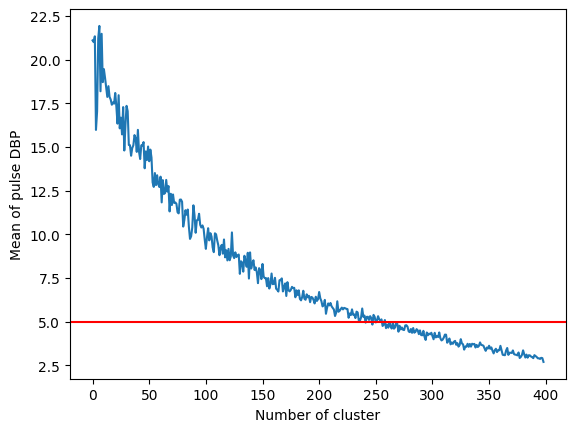

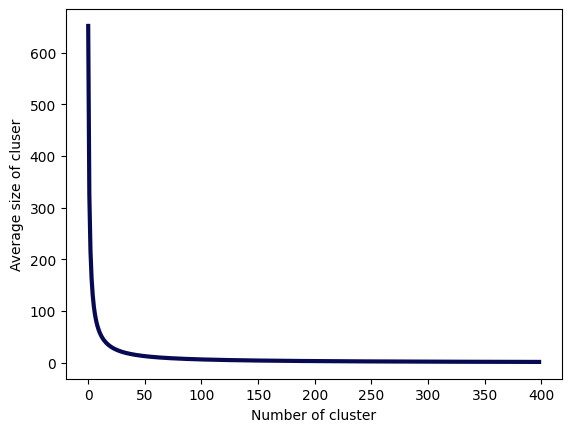

In [271]:
len(all_kmeans_sd)
plt.figure()
plt.plot(list(range(len(all_kmeans_mean))), list(all_kmeans_sd))
plt.axhline(y=5, color='r', linestyle='-')

plt.xlabel("Number of cluster")
plt.ylabel("Mean of pulse DBP")
plt.show()

len(all_kmeans_sd)
plt.figure()
plt.plot(list(range(len(all_kmeans_numbers))), list(all_kmeans_numbers),linewidth=3,color= "#070A52")
plt.xlabel("Number of cluster")
plt.ylabel("Average size of cluser")
# plt.xlim(10)
# plt.ylim(0,40)
plt.show()

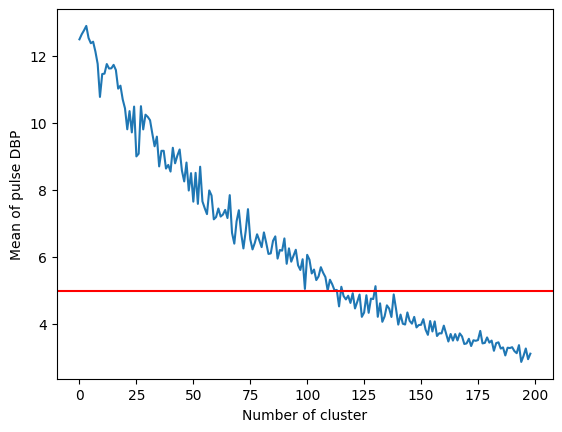

In [114]:
len(all_kmeans_sd)
plt.figure()
plt.plot(list(range(len(all_kmeans_mean))), list(all_kmeans_sd))
plt.axhline(y=5, color='r', linestyle='-')

plt.xlabel("Number of cluster")
plt.ylabel("Mean of pulse DBP")
plt.show()

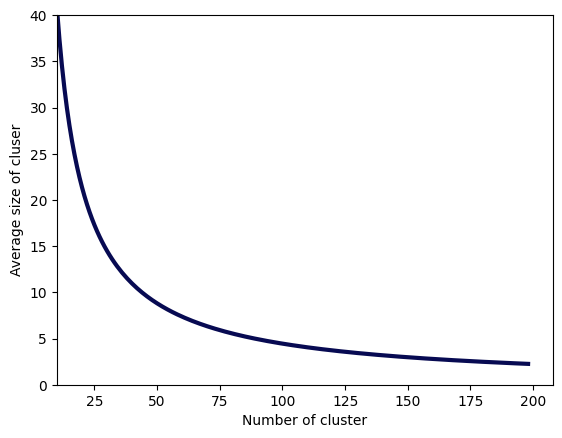

In [125]:
len(all_kmeans_sd)
plt.figure()
plt.plot(list(range(len(all_kmeans_numbers))), list(all_kmeans_numbers),linewidth=3,color= "#070A52")
plt.xlabel("Number of cluster")
plt.ylabel("Average size of cluser")
plt.xlim(10)
plt.ylim(0,40)
plt.show()

In [155]:
from sklearn.cluster import KMeans
n_clusters=5
kmeans = KMeans(n_clusters=n_clusters)

y = kmeans.fit_predict(auscultatory_pressure_real)

#print(y)
whole_cluter_mea = []
for j in range(n_clusters):
    indexes = [idx for idx, val in enumerate(y) if val == j]
    dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
    dbp_variation=list(dbp_variation)
    sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
    sbp_variation =list(sbp_variation)

    pulse_variation =  [i for j, i in enumerate(list(auscultatory_pressure_real)) if j in indexes]
    # print(round(get_stats(dbp_variation)[3],1), round(get_stats(dbp_variation)[4] - get_stats(dbp_variation)[3],1) )
    # print(round(get_stats(sbp_variation)[3],1), round(get_stats(sbp_variation)[4] - get_stats(sbp_variation)[3],1))
    # for i in indexes:
    #     plt.plot(auscultatory_pressure_real[i], color="#ED2B2A")
    
    all_mea = []
    cross_valid_space = int(len(pulse_variation)*(0.2))
    if cross_valid_space>3:
        for i in range(0,len(pulse_variation),cross_valid_space): 

            X = pulse_variation[0:i] + pulse_variation[i+cross_valid_space:len(pulse_variation)]
            Y = np.array(sbp_variation[0:i] +sbp_variation[i+cross_valid_space:len(sbp_variation)])
            
            X_other = pulse_variation[i:i+cross_valid_space] 
            Y_other = np.array(sbp_variation[i:i+cross_valid_space])
            
            X_train= np.array(X)
            Y_train= np.array(Y)

            X_test= np.array(X_other)
            Y_test= np.array(Y_other)

            

            X_test = X_test.reshape(X_test.shape[0], -1)
            Y_test = Y_test.reshape(Y_test.shape[0], -1)

            #model = LinearRegression()
            model = KNeighborsRegressor(n_neighbors=1)

            X_test = X_test.reshape(X_test.shape[0], -1)

            the_fit = model.fit(X_train, Y_train)

            y_predict= model.predict(X_test)

            all_mea.append(round(mean_absolute_error(Y_test, y_predict),2))

    #print("knn summary",[get_stats(all_mea)[3], get_stats(all_mea)[4] - get_stats(all_mea)[3] ])
    whole_cluter_mea.append(get_stats(all_mea)[3])

    


    # plt.title(f"With {len(indexes)} in the group")
    # plt.xticks([])
    # plt.yticks([])
    # plt.show()

print([get_stats(whole_cluter_mea)[3], get_stats(whole_cluter_mea)[4] - get_stats(whole_cluter_mea)[3] ])

[23.908666666666665, 3.8699008600565783]


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/2508400835.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/2508400835.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/2508400835.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

In [170]:
import math

In [234]:
whole_cluter_mea = []
for i in range (1,150,1):
    n_clusters=i
    kmeans = KMeans(n_clusters=n_clusters)

    y = kmeans.fit_predict(auscultatory_pressure_real)

    #print(y)
    cluster_all = []
    for j in range(n_clusters):
        indexes = [idx for idx, val in enumerate(y) if val == j]
        dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
        dbp_variation=list(dbp_variation)
        sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
        sbp_variation =list(sbp_variation)
        #[auscultatory_pressure_real[i] for i in range(len(list(auscultatory_pressure_real))) if j in indexes]
        pulse_variation =   [auscultatory_pressure_real[i] for i in indexes ]
        #print(pulse_variation)
        
        # print(round(get_stats(dbp_variation)[3],1), round(get_stats(dbp_variation)[4] - get_stats(dbp_variation)[3],1) )
        # print(round(get_stats(sbp_variation)[3],1), round(get_stats(sbp_variation)[4] - get_stats(sbp_variation)[3],1))
        # for i in indexes:
        #     plt.plot(auscultatory_pressure_real[i], color="#ED2B2A")
        
        #all_mea = []
        cross_valid_space = int(len(pulse_variation)*(0.1))
        if len(pulse_variation)>15 :
            all_mea = []
            for i in range(0,len(pulse_variation)-cross_valid_space,cross_valid_space): 

                X = pulse_variation[0:i] + pulse_variation[i+cross_valid_space:len(pulse_variation)]
                Y = np.array(sbp_variation[0:i] +sbp_variation[i+cross_valid_space:len(sbp_variation)])
                
                X_other = pulse_variation[i:i+cross_valid_space] 
                Y_other = np.array(sbp_variation[i:i+cross_valid_space])
                
                X_train= np.array(X)
                Y_train= np.array(Y)

                X_test= np.array(X_other)
                Y_test= np.array(Y_other)

                

                X_test = X_test.reshape(X_test.shape[0], -1)
                Y_test = Y_test.reshape(Y_test.shape[0], -1)

                #model = LinearRegression()
                model = KNeighborsRegressor(n_neighbors=5)

                X_test = X_test.reshape(X_test.shape[0], -1)

                the_fit = model.fit(X_train, Y_train)

                y_predict= model.predict(X_test)
                
               
                #if math.isnan(round(mean_absolute_error(Y_test, y_predict),2))==False:
                #print("predict",y_predict)
                #print("MEA 1:",round(mean_absolute_error(Y_test, y_predict),2))
                all_mea.append(round(mean_absolute_error(Y_test, y_predict),2))
            if len(all_mea)>0:
                cluster_all.append(get_stats(all_mea)[3])
    if len(cluster_all)>0:
        print(f"{j}'s cluster MEA", get_stats(cluster_all)[3])
        whole_cluter_mea.append(get_stats(cluster_all)[3])
     



print("total",whole_cluter_mea)

/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

0's cluster MEA 15.326999999999998
1's cluster MEA 15.113000000000001


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

2's cluster MEA 15.359


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

3's cluster MEA 15.294821428571426


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

4's cluster MEA 15.183956643356643


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

5's cluster MEA 15.190119528619528


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

6's cluster MEA 15.460229437229438


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

7's cluster MEA 14.953509157509158


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

8's cluster MEA 15.014880230880232


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

9's cluster MEA 14.868540404040402


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

10's cluster MEA 15.568608946608947


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

11's cluster MEA 14.323815309962368


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

12's cluster MEA 15.358776965458786


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

13's cluster MEA 15.198152076318744


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

14's cluster MEA 15.30588434767847


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

15's cluster MEA 14.972465151515152


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

16's cluster MEA 14.6630795039779


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

17's cluster MEA 13.948349494949493


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

18's cluster MEA 14.987982106782107


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

19's cluster MEA 14.656666333666333


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

20's cluster MEA 15.000045643601794


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

21's cluster MEA 15.223142177267176


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

22's cluster MEA 14.892140054390056


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

23's cluster MEA 15.045797979797982


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

24's cluster MEA 14.860684654234655


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

25's cluster MEA 14.623375483721075


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

26's cluster MEA 15.16513131313131


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

27's cluster MEA 14.849608544233545


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

28's cluster MEA 14.072037291140232


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

29's cluster MEA 15.48695694692018


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

30's cluster MEA 16.221276515151516


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

31's cluster MEA 14.93159341940111


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

32's cluster MEA 15.24652615313979


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

33's cluster MEA 15.632331313131314


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

34's cluster MEA 16.600966200466203


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

35's cluster MEA 17.113515151515156


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

36's cluster MEA 15.722740546490549


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

37's cluster MEA 15.154121561771564


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

38's cluster MEA 15.084482940262355


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

39's cluster MEA 16.07952952602953


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

40's cluster MEA 16.040333819478207


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

41's cluster MEA 15.800820473970472


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

42's cluster MEA 15.606677890011222


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

43's cluster MEA 16.193769279331782


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

44's cluster MEA 15.687347751268343


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

45's cluster MEA 16.844290849673204


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

46's cluster MEA 15.569765300059418


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

47's cluster MEA 16.129396367521366


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

48's cluster MEA 15.655183864791711


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

49's cluster MEA 15.020956369406736


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

50's cluster MEA 16.069755935422606


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

51's cluster MEA 16.49165714840715


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

52's cluster MEA 16.816690972222226


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

53's cluster MEA 16.73089425770308


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

54's cluster MEA 15.580557467532469


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

55's cluster MEA 16.798139730639733


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

56's cluster MEA 16.03524831649831


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

57's cluster MEA 16.05341358024691


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

58's cluster MEA 16.239440065769895


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

59's cluster MEA 15.748861832611833


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

60's cluster MEA 16.798756740196076


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

61's cluster MEA 18.104224736048266


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

62's cluster MEA 16.619832013574662


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

63's cluster MEA 16.448454809533242


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

64's cluster MEA 14.950675505050505


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

65's cluster MEA 16.70502857334659


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

66's cluster MEA 15.334223484848486


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

67's cluster MEA 16.91845486111111


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

68's cluster MEA 16.667701465201464


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

69's cluster MEA 16.497749396681748


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

70's cluster MEA 15.745122177658944


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

71's cluster MEA 16.78623148148148


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

72's cluster MEA 16.488355392156862


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

73's cluster MEA 18.022653000594175


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

74's cluster MEA 17.58883414334395


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

75's cluster MEA 17.42175925925926


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

76's cluster MEA 15.888444083694084


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

77's cluster MEA 17.67649628353672


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

78's cluster MEA 17.285614718614717


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

79's cluster MEA 16.333254419191917


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

80's cluster MEA 17.437674456988184


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

81's cluster MEA 17.842770940170944


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

82's cluster MEA 16.421013071895427


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

83's cluster MEA 17.653074494949497


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

84's cluster MEA 17.578311868686868


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

85's cluster MEA 17.52609577922078


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

86's cluster MEA 15.407508826957356


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

87's cluster MEA 18.074484126984128


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

88's cluster MEA 16.50460410830999


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

89's cluster MEA 16.831684967320264


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

90's cluster MEA 18.60193681318681


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

91's cluster MEA 17.06854797979798


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

92's cluster MEA 16.635215601392073


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

93's cluster MEA 16.288385225885225


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

94's cluster MEA 18.237742424242427


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

95's cluster MEA 16.951256978315804


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

96's cluster MEA 17.02383945031004


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

97's cluster MEA 17.723993055555553


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

98's cluster MEA 18.798972416472417


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

99's cluster MEA 17.299536907536908


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

100's cluster MEA 18.77035173160173


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

101's cluster MEA 20.44532828282828


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

102's cluster MEA 22.445882352941172


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

103's cluster MEA 18.345526960784316


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

104's cluster MEA 15.116416666666666


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

105's cluster MEA 17.878305429864252


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

106's cluster MEA 16.74178888888889


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

107's cluster MEA 18.02760695187166
108's cluster MEA 14.803333333333331


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

109's cluster MEA 18.07933006535948


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

110's cluster MEA 17.798858998144713


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

111's cluster MEA 18.396666666666665


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

112's cluster MEA 16.841511437908498


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

113's cluster MEA 17.187628676470588


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

114's cluster MEA 19.853358585858587


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

115's cluster MEA 19.090259709653093


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

116's cluster MEA 19.166462418300657


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

117's cluster MEA 16.210588235294118


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

118's cluster MEA 18.27246434937611


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

119's cluster MEA 16.28192810457516
120's cluster MEA 16.83


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

121's cluster MEA 17.973983585858583


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

122's cluster MEA 20.792878787878788


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

123's cluster MEA 17.217638888888885


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

124's cluster MEA 17.435972222222226
125's cluster MEA 20.964166666666664


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

126's cluster MEA 19.341041666666666


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

127's cluster MEA 19.118333333333336


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

128's cluster MEA 20.369747474747477


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

129's cluster MEA 18.510099715099717


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

130's cluster MEA 17.185294117647057
131's cluster MEA 20.118750000000002


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

132's cluster MEA 19.13255555555556


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

133's cluster MEA 19.858333333333334


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

134's cluster MEA 17.398809523809526
135's cluster MEA 14.802499999999998


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

136's cluster MEA 21.735294117647058
137's cluster MEA 14.04090909090909


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

138's cluster MEA 16.7987037037037


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

139's cluster MEA 19.34861111111111


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

140's cluster MEA 21.80560185185185


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

141's cluster MEA 18.93287037037037


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

142's cluster MEA 18.33


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

143's cluster MEA 23.2625


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

144's cluster MEA 19.797777777777778
145's cluster MEA 18.46875


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

146's cluster MEA 20.735833333333332


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

147's cluster MEA 14.43888888888889
148's cluster MEA 21.7
total [15.326999999999998, 15.113000000000001, 15.359, 15.294821428571426, 15.183956643356643, 15.190119528619528, 15.460229437229438, 14.953509157509158, 15.014880230880232, 14.868540404040402, 15.568608946608947, 14.323815309962368, 15.358776965458786, 15.198152076318744, 15.30588434767847, 14.972465151515152, 14.6630795039779, 13.948349494949493, 14.987982106782107, 14.656666333666333, 15.000045643601794, 15.223142177267176, 14.892140054390056, 15.045797979797982, 14.860684654234655, 14.623375483721075, 15.16513131313131, 14.849608544233545, 14.072037291140232, 15.48695694692018, 16.221276515151516, 14.93159341940111, 15.24652615313979, 15.632331313131314, 16.600966200466203, 17.113515151515156, 15.722740546490549, 15.154121561771564, 15.084482940262355, 16.07952952602953, 16.040333819478207, 15.800820473970472, 15.606677890011222, 16.193769279331782, 15.687347751268343, 16.844290849673204, 15.569765300059418, 16.12939636752

/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3435475201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]


[15.326999999999998, 15.113000000000001, 15.359, 15.294821428571426, 15.183956643356643, 15.190119528619528, 15.460229437229438, 14.953509157509158, 15.014880230880232, 14.868540404040402, 15.568608946608947, 14.323815309962368, 15.358776965458786, 15.198152076318744, 15.30588434767847, 14.972465151515152, 14.6630795039779, 13.948349494949493, 14.987982106782107, 14.656666333666333, 15.000045643601794, 15.223142177267176, 14.892140054390056, 15.045797979797982, 14.860684654234655, 14.623375483721075, 15.16513131313131, 14.849608544233545, 14.072037291140232, 15.48695694692018, 16.221276515151516, 14.93159341940111, 15.24652615313979, 15.632331313131314, 16.600966200466203, 17.113515151515156, 15.722740546490549, 15.154121561771564, 15.084482940262355, 16.07952952602953, 16.040333819478207, 15.800820473970472, 15.606677890011222, 16.193769279331782, 15.687347751268343, 16.844290849673204, 15.569765300059418, 16.129396367521366, 15.655183864791711, 15.020956369406736, 16.069755935422606,

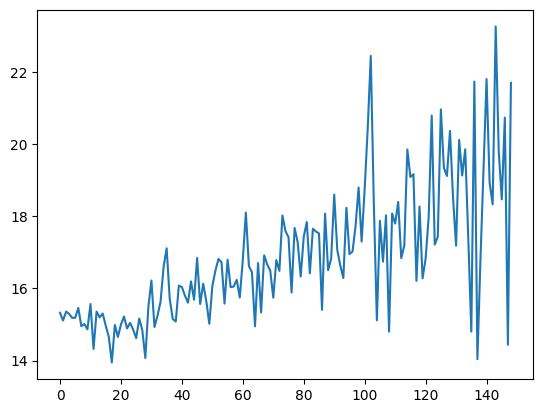

In [236]:
print(whole_cluter_mea)
whole_cluter_mea_1=whole_cluter_mea
plt.plot(whole_cluter_mea)

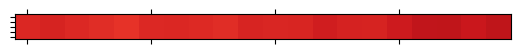

<Figure size 400x400 with 0 Axes>

In [226]:
data = np.matrix(whole_cluter_mea)

fig, ax = plt.subplots()
plt.figure(figsize=(4, 4)) 
cmap = matplotlib.colors.ListedColormap(['white','red'])

# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(data, cmap='Reds', vmin=0, vmax=15)
age_keys = used_clusters
plt.rcParams.update({'font.size': 10})
ax.set_xticklabels([])
ax.set_yticklabels([])


for (i, j), z in np.ndenumerate(data):
    ax.text(j, i, f"", ha='center', va='center', color = "white")
#bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3' )

plt.show()

In [238]:
whole_cluter_mea = []
used_clusters= []
for i in range (1,150,1):
    n_clusters=i
    kmeans = KMeans(n_clusters=n_clusters)

    y = kmeans.fit_predict(auscultatory_pressure_real)

    #print(y)
    cluster_all = []
    for j in range(n_clusters):
        indexes = [idx for idx, val in enumerate(y) if val == j]
        dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
        dbp_variation=list(dbp_variation)
        sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
        sbp_variation =list(sbp_variation)
        #[auscultatory_pressure_real[i] for i in range(len(list(auscultatory_pressure_real))) if j in indexes]
        pulse_variation =   [auscultatory_pressure_real[i] for i in indexes ]
        #print(pulse_variation)
        
        # print(round(get_stats(dbp_variation)[3],1), round(get_stats(dbp_variation)[4] - get_stats(dbp_variation)[3],1) )
        # print(round(get_stats(sbp_variation)[3],1), round(get_stats(sbp_variation)[4] - get_stats(sbp_variation)[3],1))
        # for i in indexes:
        #     plt.plot(auscultatory_pressure_real[i], color="#ED2B2A")
        
        #all_mea = []
        cross_valid_space = int(len(pulse_variation)*(0.1))
        if len(pulse_variation)>15 :
            all_mea = []
            for i in range(0,len(pulse_variation)-cross_valid_space,cross_valid_space): 

                X = pulse_variation[0:i] + pulse_variation[i+cross_valid_space:len(pulse_variation)]
                Y = np.array(dbp_variation[0:i] +dbp_variation[i+cross_valid_space:len(dbp_variation)])
                
                X_other = pulse_variation[i:i+cross_valid_space] 
                Y_other = np.array(dbp_variation[i:i+cross_valid_space])
                
                X_train= np.array(X)
                Y_train= np.array(Y)

                X_test= np.array(X_other)
                Y_test= np.array(Y_other)

                

                X_test = X_test.reshape(X_test.shape[0], -1)
                Y_test = Y_test.reshape(Y_test.shape[0], -1)

                #model = LinearRegression()
                model = KNeighborsRegressor(n_neighbors=5)

                X_test = X_test.reshape(X_test.shape[0], -1)

                the_fit = model.fit(X_train, Y_train)

                y_predict= model.predict(X_test)
                
               
                #if math.isnan(round(mean_absolute_error(Y_test, y_predict),2))==False:
                #print("predict",y_predict)
                #print("MEA 1:",round(mean_absolute_error(Y_test, y_predict),2))
                all_mea.append(round(mean_absolute_error(Y_test, y_predict),2))
            if len(all_mea)>0:
                cluster_all.append(get_stats(all_mea)[3])
    if len(cluster_all)>0:
        print(f"{j}'s cluster MEA", get_stats(cluster_all)[3])
        whole_cluter_mea.append(get_stats(cluster_all)[3])
        used_clusters.append(n_clusters)
     



print("total",whole_cluter_mea)

/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

0's cluster MEA 10.396999999999998


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]


1's cluster MEA 10.475999999999999


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

2's cluster MEA 10.495777777777777


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

3's cluster MEA 10.69332142857143


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

4's cluster MEA 10.626900000000001


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

5's cluster MEA 10.606200000000001


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

6's cluster MEA 10.949587542087542


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

7's cluster MEA 10.40716835016835


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

8's cluster MEA 10.595856698856702


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

9's cluster MEA 10.801696063196063


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

10's cluster MEA 10.565839646464646


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

11's cluster MEA 10.07898709315376


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

12's cluster MEA 10.38017396184063


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

13's cluster MEA 10.347566102198455


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

14's cluster MEA 10.060545260295259


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

15's cluster MEA 10.216098484848484


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

16's cluster MEA 10.47116866630102


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

17's cluster MEA 9.67077441077441


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

18's cluster MEA 10.041259312582842


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

19's cluster MEA 10.488947346770876


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

20's cluster MEA 10.416526515151515


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

21's cluster MEA 9.942399305555554


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

22's cluster MEA 9.956287601287602


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

23's cluster MEA 10.117585908446872


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

24's cluster MEA 10.215576213492389


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

25's cluster MEA 10.54045172882673


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

26's cluster MEA 10.154032106782108


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

27's cluster MEA 10.427567094017094


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

28's cluster MEA 10.098520102990692


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

29's cluster MEA 9.870600127323657


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

30's cluster MEA 10.711080437684714


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

31's cluster MEA 10.0326158008658


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

32's cluster MEA 10.366039109039109


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

33's cluster MEA 10.510064920373745


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

34's cluster MEA 9.494146005509641


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

35's cluster MEA 10.099519806488134


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

36's cluster MEA 10.39535122053872


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

37's cluster MEA 10.335728423945335


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

38's cluster MEA 10.746998774509805


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

39's cluster MEA 10.24596041295306


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

40's cluster MEA 10.23504355089355


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

41's cluster MEA 10.375493395493397


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

42's cluster MEA 10.191608691961632


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

43's cluster MEA 10.206019431367471


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

44's cluster MEA 10.412522095959597


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

45's cluster MEA 10.454531662781664


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

46's cluster MEA 10.200016988062442


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

47's cluster MEA 10.663287037037037


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

48's cluster MEA 10.49893365472911


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

49's cluster MEA 10.93568465909091


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

50's cluster MEA 10.516219008264464


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

51's cluster MEA 10.606781720095448


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

52's cluster MEA 10.23000038723078


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

53's cluster MEA 10.696857628573314


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

54's cluster MEA 10.794493551587301


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

55's cluster MEA 10.966243563081798


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

56's cluster MEA 10.479617435034102


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

57's cluster MEA 10.905713507625272


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

58's cluster MEA 10.168775252525254


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

59's cluster MEA 10.641314935064932


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

60's cluster MEA 10.15336940836941


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

61's cluster MEA 10.308661240720065


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

62's cluster MEA 10.428016299357209


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

63's cluster MEA 10.543433363042187


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

64's cluster MEA 11.523236494597839


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

65's cluster MEA 11.087219288472966


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

66's cluster MEA 10.291335148874365


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

67's cluster MEA 11.109099326599326


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

68's cluster MEA 11.540646825396824


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

69's cluster MEA 10.67428055060408


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

70's cluster MEA 11.123177447552447


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

71's cluster MEA 10.512651467994607


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

72's cluster MEA 10.888891478891479


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

73's cluster MEA 11.198993824802647


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

74's cluster MEA 11.034324494949495


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

75's cluster MEA 10.389558696205755


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

76's cluster MEA 11.530071078431373


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

77's cluster MEA 11.14393170248869


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

78's cluster MEA 11.238709401709402


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

79's cluster MEA 11.159800835148873


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

80's cluster MEA 12.055065359477124


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

81's cluster MEA 10.971333333333332


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

82's cluster MEA 11.796471121471122


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

83's cluster MEA 10.739214015151514


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

84's cluster MEA 10.825625


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

85's cluster MEA 12.773330362448009


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

86's cluster MEA 12.329154348919053


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

87's cluster MEA 11.654715384615383


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

88's cluster MEA 10.250601400029709


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

89's cluster MEA 11.96839707977208


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

90's cluster MEA 10.935873015873016


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

91's cluster MEA 12.020370370370372


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

92's cluster MEA 11.44576470588235
93's cluster MEA 12.56962210338681


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

94's cluster MEA 10.990869658119658


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

95's cluster MEA 11.427242063492063


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

96's cluster MEA 12.807444444444446


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

97's cluster MEA 11.077716450216451


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

98's cluster MEA 12.908559523809524


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

99's cluster MEA 11.763451388888889


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

100's cluster MEA 12.385666666666665


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

101's cluster MEA 11.06377314814815


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

102's cluster MEA 10.960766317016317


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

103's cluster MEA 11.137313131313132
104's cluster MEA 12.134478114478114


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

105's cluster MEA 11.410175324675325


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

106's cluster MEA 10.932175925925925


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

107's cluster MEA 11.63130362828892


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

108's cluster MEA 12.077924208144797


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

109's cluster MEA 12.075705128205128


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

110's cluster MEA 11.170181713711125


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

111's cluster MEA 11.863933452168745
112's cluster MEA 12.156378205128204


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

113's cluster MEA 11.56545751633987


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

114's cluster MEA 12.68890639589169


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

115's cluster MEA 11.060416666666665
116's cluster MEA 10.494444444444445


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

117's cluster MEA 11.549583333333333


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

118's cluster MEA 11.392291666666667
119's cluster MEA 12.750865384615382


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

120's cluster MEA 11.611638257575757


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

121's cluster MEA 10.11875
122's cluster MEA 10.129166666666668


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

123's cluster MEA 11.792592592592593


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

124's cluster MEA 10.707407407407407


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

125's cluster MEA 11.821323529411764
126's cluster MEA 12.191018518518518


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

127's cluster MEA 11.580740740740742


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

128's cluster MEA 11.952924836601305


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

129's cluster MEA 11.466032679738564


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

130's cluster MEA 11.133020833333333


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

131's cluster MEA 10.891394335511983


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

132's cluster MEA 11.040624999999999


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

133's cluster MEA 11.789720179738563
134's cluster MEA 11.3125


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

135's cluster MEA 12.463888888888889


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

136's cluster MEA 10.657339324618738
137's cluster MEA 10.594444444444443


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

138's cluster MEA 11.864421296296298


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

139's cluster MEA 11.77577614379085


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

140's cluster MEA 10.467777777777778


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

141's cluster MEA 11.034949494949496


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

142's cluster MEA 12.778416666666667
143's cluster MEA 11.764814814814814


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

144's cluster MEA 12.107429193899783


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

146's cluster MEA 12.555208333333335


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

147's cluster MEA 10.789583333333333


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/3096541403.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9b

148's cluster MEA 11.064166666666667
total [10.396999999999998, 10.475999999999999, 10.495777777777777, 10.69332142857143, 10.626900000000001, 10.606200000000001, 10.949587542087542, 10.40716835016835, 10.595856698856702, 10.801696063196063, 10.565839646464646, 10.07898709315376, 10.38017396184063, 10.347566102198455, 10.060545260295259, 10.216098484848484, 10.47116866630102, 9.67077441077441, 10.041259312582842, 10.488947346770876, 10.416526515151515, 9.942399305555554, 9.956287601287602, 10.117585908446872, 10.215576213492389, 10.54045172882673, 10.154032106782108, 10.427567094017094, 10.098520102990692, 9.870600127323657, 10.711080437684714, 10.0326158008658, 10.366039109039109, 10.510064920373745, 9.494146005509641, 10.099519806488134, 10.39535122053872, 10.335728423945335, 10.746998774509805, 10.24596041295306, 10.23504355089355, 10.375493395493397, 10.191608691961632, 10.206019431367471, 10.412522095959597, 10.454531662781664, 10.200016988062442, 10.663287037037037, 10.4989336547

[10.396999999999998, 10.475999999999999, 10.495777777777777, 10.69332142857143, 10.626900000000001, 10.606200000000001, 10.949587542087542, 10.40716835016835, 10.595856698856702, 10.801696063196063, 10.565839646464646, 10.07898709315376, 10.38017396184063, 10.347566102198455, 10.060545260295259, 10.216098484848484, 10.47116866630102, 9.67077441077441, 10.041259312582842, 10.488947346770876, 10.416526515151515, 9.942399305555554, 9.956287601287602, 10.117585908446872, 10.215576213492389, 10.54045172882673, 10.154032106782108, 10.427567094017094, 10.098520102990692, 9.870600127323657, 10.711080437684714, 10.0326158008658, 10.366039109039109, 10.510064920373745, 9.494146005509641, 10.099519806488134, 10.39535122053872, 10.335728423945335, 10.746998774509805, 10.24596041295306, 10.23504355089355, 10.375493395493397, 10.191608691961632, 10.206019431367471, 10.412522095959597, 10.454531662781664, 10.200016988062442, 10.663287037037037, 10.49893365472911, 10.93568465909091, 10.516219008264464

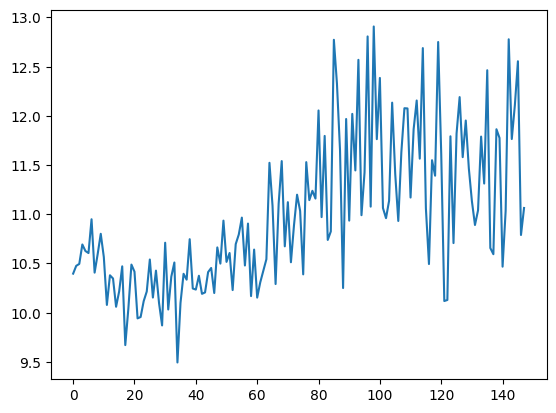

In [239]:
print(whole_cluter_mea)
whole_cluter_mea_2=whole_cluter_mea
plt.plot(whole_cluter_mea)

<function matplotlib.pyplot.show(close=None, block=None)>

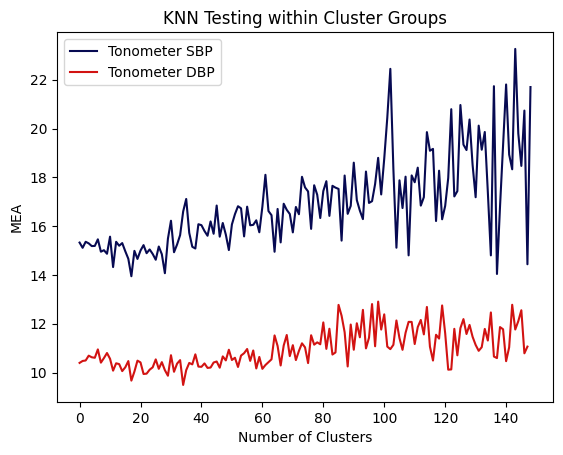

In [246]:
plt.plot(whole_cluter_mea_1,color="#070A52", label="Tonometer SBP")
plt.plot(whole_cluter_mea_2, color  = "#D21312",label="Tonometer DBP")
plt.legend(loc='best')
plt.xlabel("Number of Clusters")
plt.ylabel("MEA")
plt.title("KNN Testing within Cluster Groups")
plt.show
# "#070A52", "#F15A59","#D21312"

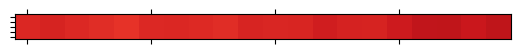

<Figure size 400x400 with 0 Axes>

In [225]:
data = np.matrix(whole_cluter_mea)

fig, ax = plt.subplots()
plt.figure(figsize=(4, 4)) 
cmap = matplotlib.colors.ListedColormap(['white','red'])

# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(data, cmap='Reds', vmin=0, vmax=15)
age_keys = used_clusters
plt.rcParams.update({'font.size': 10})
ax.set_xticklabels([])
ax.set_yticklabels([])


for (i, j), z in np.ndenumerate(data):
    ax.text(j, i, f"", ha='center', va='center', color = "white")
#bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3' )

plt.show()

In [132]:
# sse = {}
# list_clusters= [ ]
# for k in range(1, 50):
#     kmeans = KMeans(n_clusters=k,  max_iter = 500).fit(auscultatory_pressure_real)
    
#     #print(data["clusters"])
#     sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

#     # sse[k] = sum(np.min(cdist(auscultatory_pressure_real, kmeanModel.cluster_centers_,
#     #                                     'euclidean'), axis=1)) / auscultatory_pressure_real.shape[0]
# plt.figure()
# plt.plot(list(sse.keys()), list(sse.values()))
# plt.xlabel("Number of cluster")
# plt.ylabel("SSE")
# plt.show()

In [250]:
auscultatory_pressure_simulated, auscultatory_dbp_simulated = filter_charlton_subjects()

[77.28301351351351, 1.5202692417413886]


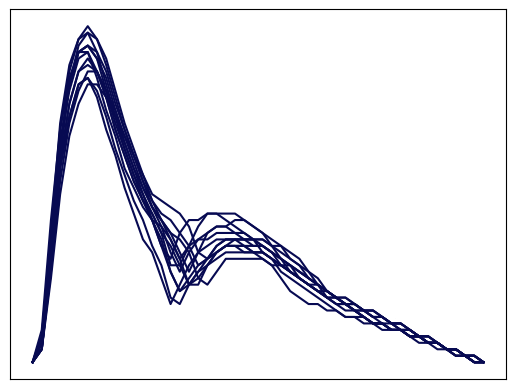

[77.22768493150686, 1.5004088518299454]


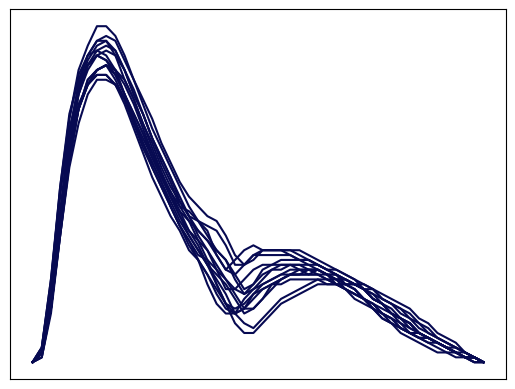

[77.34641843971632, 1.5003387709930962]


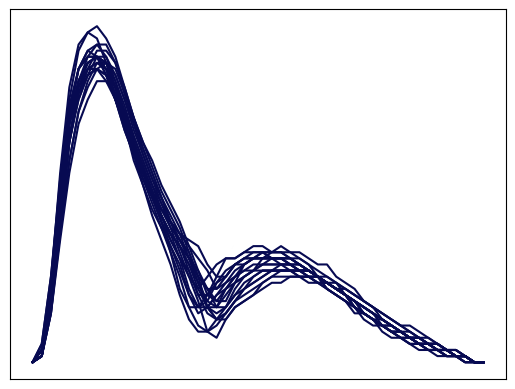

[77.26899295774649, 1.5409886276850386]


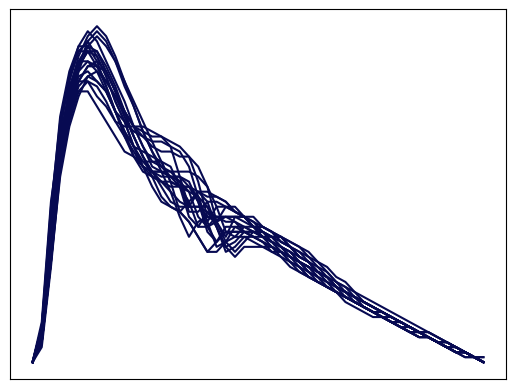

[77.34284313725492, 1.536931324738589]


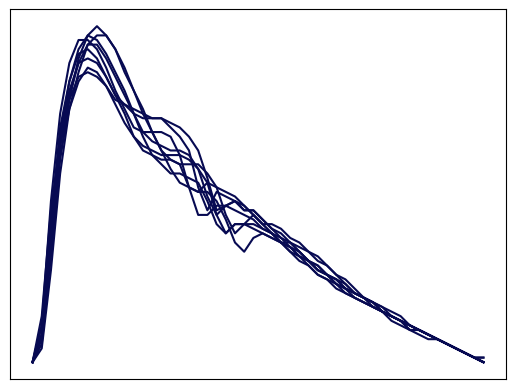

[77.39726845637584, 1.4986980015143985]


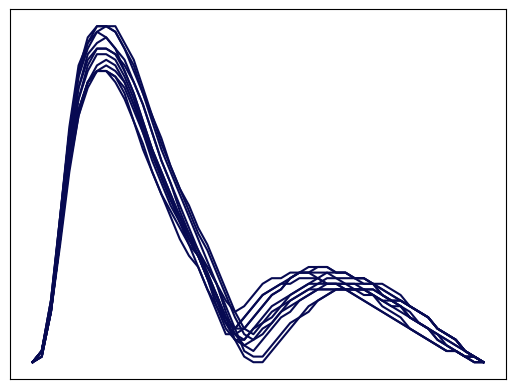

[77.37104827586207, 1.4935714537057123]


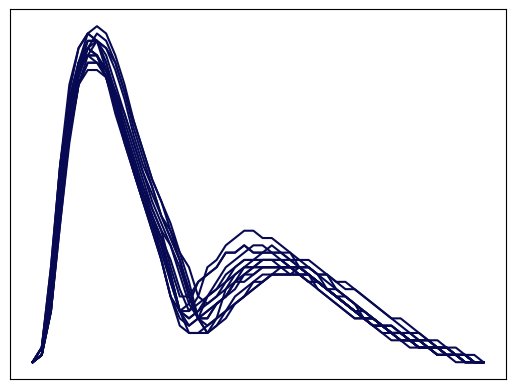

[77.23774285714285, 1.532457654373843]


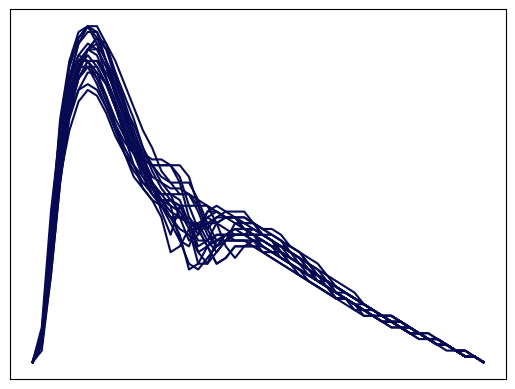

[77.34684931506848, 1.5099044483170019]


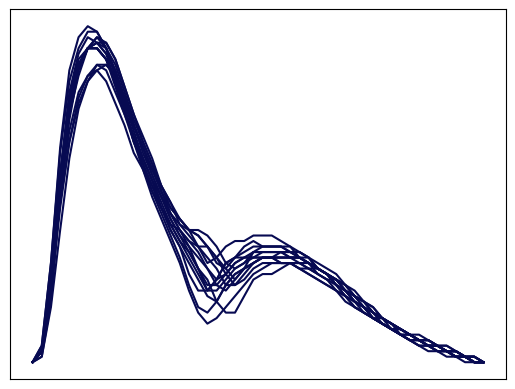

[77.38650675675676, 1.4980039083439607]


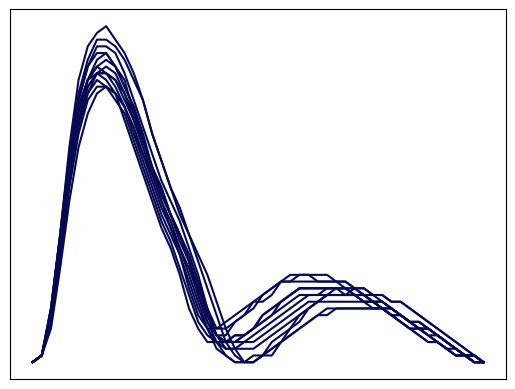

In [259]:
from sklearn.cluster import KMeans
n_clusters=10
kmeans = KMeans(n_clusters=n_clusters)

y = kmeans.fit_predict(auscultatory_pressure_simulated)

#print(y)
for j in range(n_clusters):
    indexes = [idx for idx, val in enumerate(y) if val == j]

    dps_variation = [i for j, i in enumerate(auscultatory_dbp_simulated) if j not in indexes]
    print([get_stats(dps_variation)[3], get_stats(dps_variation)[4] - get_stats(dps_variation)[3] ])
    for i in indexes:
        plt.plot(auscultatory_pressure_simulated[i], color= "#070A52")
    #plt.title(f"With {len(indexes)} in the group")
    plt.xticks([])
    plt.yticks([])
    plt.show()

<Figure size 1000x1000 with 0 Axes>

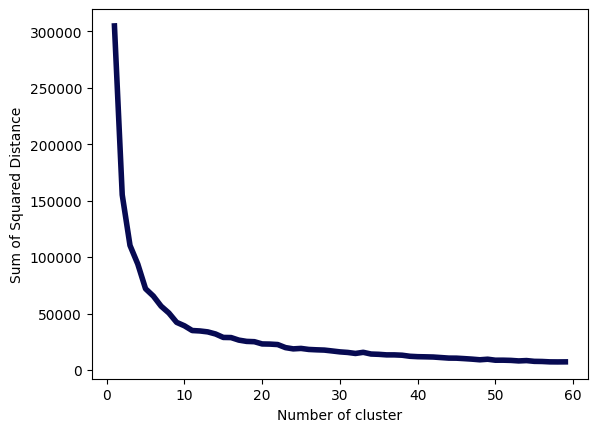

In [22]:
plt.figure(figsize=(10, 10)) 
sse = {}
list_clusters= [ ]
for k in range(1, 60):
    kmeans = KMeans(n_clusters=k,  max_iter = 500).fit(auscultatory_pressure_simulated[:])
    
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), linewidth=4, color= "#070A52")
plt.xlabel("Number of cluster")
plt.ylabel("Sum of Squared Distance")
plt.show()

In [205]:
# for simulated

In [229]:
whole_cluter_mea = []
for i in range (1,10,):
    n_clusters=i
    kmeans = KMeans(n_clusters=n_clusters)

    y = kmeans.fit_predict(auscultatory_pressure_simulated)

    #print(y)
    cluster_all = []
    for j in range(n_clusters):
        indexes = [idx for idx, val in enumerate(y) if val == j]
        dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_simulated)) if j in indexes]
        dbp_variation=list(dbp_variation)
        
        #[auscultatory_pressure_real[i] for i in range(len(list(auscultatory_pressure_real))) if j in indexes]
        pulse_variation =   [auscultatory_pressure_simulated[i] for i in indexes ]
        #print(pulse_variation)
        
        # print(round(get_stats(dbp_variation)[3],1), round(get_stats(dbp_variation)[4] - get_stats(dbp_variation)[3],1) )
        # print(round(get_stats(sbp_variation)[3],1), round(get_stats(sbp_variation)[4] - get_stats(sbp_variation)[3],1))
        # for i in indexes:
        #     plt.plot(auscultatory_pressure_real[i], color="#ED2B2A")
        
        #all_mea = []
        cross_valid_space = int(len(pulse_variation)*(0.1))
        if len(pulse_variation)>10 :
            all_mea = []
            for i in range(0,len(pulse_variation)-cross_valid_space,cross_valid_space): 

                X = pulse_variation[0:i] + pulse_variation[i+cross_valid_space:len(pulse_variation)]
                Y = np.array(dbp_variation[0:i] +dbp_variation[i+cross_valid_space:len(dbp_variation)])
                
                X_other = pulse_variation[i:i+cross_valid_space] 
                Y_other = np.array(dbp_variation[i:i+cross_valid_space])
                
                X_train= np.array(X)
                Y_train= np.array(Y)

                X_test= np.array(X_other)
                Y_test= np.array(Y_other)

                

                X_test = X_test.reshape(X_test.shape[0], -1)
                Y_test = Y_test.reshape(Y_test.shape[0], -1)

                #model = LinearRegression()
                model = KNeighborsRegressor(n_neighbors=5)

                X_test = X_test.reshape(X_test.shape[0], -1)

                the_fit = model.fit(X_train, Y_train)

                y_predict= model.predict(X_test)
                
               
                #if math.isnan(round(mean_absolute_error(Y_test, y_predict),2))==False:
                #print("predict",y_predict)
                #print("MEA 1:",round(mean_absolute_error(Y_test, y_predict),2))
                all_mea.append(round(mean_absolute_error(Y_test, y_predict),2))
            if len(all_mea)>0:
                cluster_all.append(get_stats(all_mea)[3])
    if len(cluster_all)>0:
        print(f"{j}'s cluster MEA", get_stats(cluster_all)[3])
        whole_cluter_mea.append(get_stats(cluster_all)[3])
     



print("total",whole_cluter_mea)

0's cluster MEA 1.4289999999999998
1's cluster MEA 1.355590909090909
2's cluster MEA 1.3093636363636365
3's cluster MEA 1.300354895104895
4's cluster MEA 1.3426777777777776
5's cluster MEA 1.370551515151515
6's cluster MEA 1.3153152033152034
7's cluster MEA 1.3372922593279737
8's cluster MEA 1.3701636557886558
total [1.4289999999999998, 1.355590909090909, 1.3093636363636365, 1.300354895104895, 1.3426777777777776, 1.370551515151515, 1.3153152033152034, 1.3372922593279737, 1.3701636557886558]


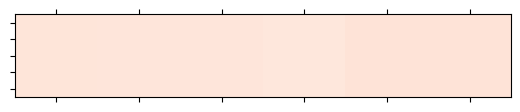

<Figure size 400x400 with 0 Axes>

In [228]:
data = np.matrix(whole_cluter_mea)

fig, ax = plt.subplots()
plt.figure(figsize=(4, 4)) 
cmap = matplotlib.colors.ListedColormap(['white','red'])

# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(data, cmap='Reds', vmin=0, vmax=15)
age_keys = used_clusters
plt.rcParams.update({'font.size': 10})
ax.set_xticklabels([])
ax.set_yticklabels([])


for (i, j), z in np.ndenumerate(data):
    ax.text(j, i, f"", ha='center', va='center', color = "white")
#bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3' )

plt.show()